In [ ]:
from matplotlib import image
from matplotlib import pyplot
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix

DataPreProcessing:

0 1 2 3 4 5 6 7 8 9 a b c d e f g h i j k l m n o p q r s t u v w x y z uint8 (400, 400, 3)
(2515, 400, 400, 3) (2515,) 36
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


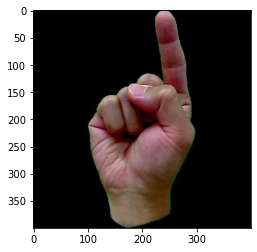

In [72]:
path = './asl_dataset/'
data,rawLabel = [],[]
labelTypes=[]
for root, dirs, files in os.walk(path):
    key = os.path.basename(root)
    if key=="": continue
    labelTypes.append(key)
    print(key, end=' ')
    for file in files:
        full_file_path = os.path.join(root,file)
        img = image.imread(full_file_path)
        data.append(img)
        rawLabel.append(key)

data = np.array(data)/255.0
rawLabel = np.array(rawLabel)
labelNum=len(labelTypes)
print(img.dtype,img.shape)
pyplot.imshow(img)
print(data.shape,rawLabel.shape,labelNum)
print(labelTypes)

In [73]:
label=np.array([[rawLabel[i]==labelTypes[j] for j in range(labelNum)]for i in range(len(rawLabel))]).astype('f4')
print(label.shape)
print(label[0])
print(label[-1])

(2515, 36)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


#split data into train and test for cross validation

In [74]:
X_train,X_use,y_train,y_use  = model_selection.train_test_split(data, label, train_size=0.8, shuffle=True)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_use, y_use, train_size=0.5, shuffle=True)
print(X_train.shape, X_test.shape,X_val.shape, y_train.shape, y_test.shape,y_val.shape)

(2012, 400, 400, 3) (251, 400, 400, 3) (252, 400, 400, 3) (2012, 36) (251, 36) (252, 36)


In [75]:
X_trainTensor=tf.constant(X_train)
X_testTensor=tf.constant(X_test)
X_valTensor=tf.constant(X_val)
Y_trainTensor=tf.constant(y_train)
Y_testTensor=tf.constant(y_test)
Y_valTensor=tf.constant(y_val)
print(X_trainTensor.shape,Y_trainTensor.shape)

(2012, 400, 400, 3) (2012, 36)


Data Analysis:

By observing the following histgram, 

we find that each type of images are almost the same amount(70).

By looking through each data type folder, 

we find that the qulities of each type of data is presistent.

(array([70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 65., 70., 70., 70., 70., 70., 70.]),
 array([ 0.        ,  0.97222222,  1.94444444,  2.91666667,  3.88888889,
         4.86111111,  5.83333333,  6.80555556,  7.77777778,  8.75      ,
         9.72222222, 10.69444444, 11.66666667, 12.63888889, 13.61111111,
        14.58333333, 15.55555556, 16.52777778, 17.5       , 18.47222222,
        19.44444444, 20.41666667, 21.38888889, 22.36111111, 23.33333333,
        24.30555556, 25.27777778, 26.25      , 27.22222222, 28.19444444,
        29.16666667, 30.13888889, 31.11111111, 32.08333333, 33.05555556,
        34.02777778, 35.        ]),
 <BarContainer object of 36 artists>)

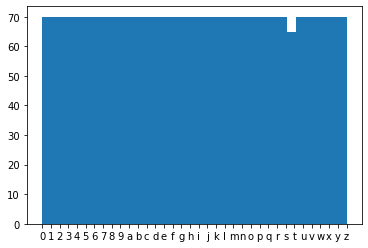

In [76]:
pyplot.hist(rawLabel,bins=labelNum)

One-Channel-AutoEncoders:

Here we'll build 3 different One-Channel-AutoEncoders which encode original 400*400*3 graphs into:

1) 20x20x1

2) 10x10x1

3) 5x5x1

In [ ]:
class AutoEncoder1(keras.Model):
  def __init__(self):
    super(AutoEncoder1, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(5, 5),strides=(5, 5), padding='same'),
      layers.Conv2D(2, (3,3), activation = 'relu',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(1, (3,3), activation = 'sigmoid',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder1=AutoEncoder1()
autoencoder1.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history1 = autoencoder1.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Model: "auto_encoder1_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_42 (Sequential)  (None, 20, 20, 1)         75        
                                                                 
 sequential_43 (Sequential)  (None, 400, 400, 3)       1261      
                                                                 
Total params: 1,336
Trainable params: 1,320
Non-trainable params: 16
_________________________________________________________________


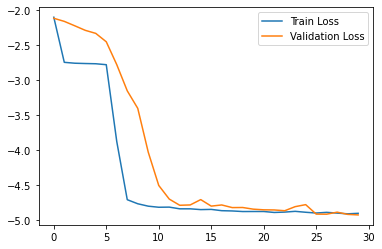

In [130]:
autoencoder1.summary()
pyplot.plot(np.log(history1.history['loss']), label='Train Loss')
pyplot.plot(np.log(history1.history['val_loss']), label='Validation Loss')
pyplot.legend()
pyplot.show()

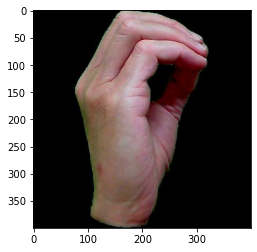

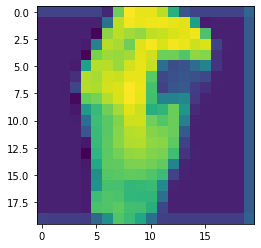

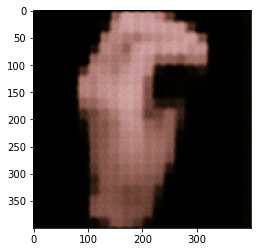

In [82]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder1.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=autoencoder1.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [ ]:
class AutoEncoder2(keras.Model):
  def __init__(self):
    super(AutoEncoder2, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(2, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(1, (3,3),strides=1,activation="sigmoid",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(5,5),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=1,activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder2=AutoEncoder2()
autoencoder2.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history2 = autoencoder2.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Model: "auto_encoder2_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_44 (Sequential)  (None, 10, 10, 1)         75        
                                                                 
 sequential_45 (Sequential)  (None, 400, 400, 3)       2357      
                                                                 
Total params: 2,432
Trainable params: 2,416
Non-trainable params: 16
_________________________________________________________________


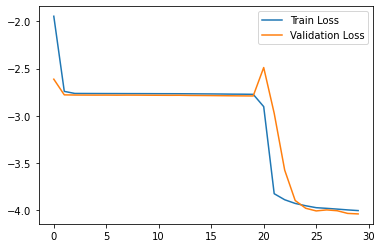

In [131]:
autoencoder2.summary()
pyplot.plot(np.log(history2.history['loss']), label='Train Loss')
pyplot.plot(np.log(history2.history['val_loss']), label='Validation Loss')
pyplot.legend()
pyplot.show()

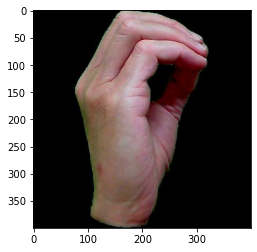

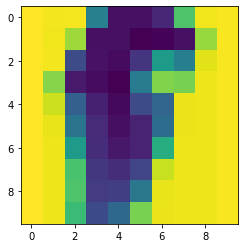

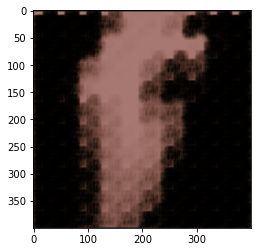

In [85]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder2.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=autoencoder2.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [ ]:
class AutoEncoder3(keras.Model):
  def __init__(self):
    super(AutoEncoder3, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(4, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(2, (3,3),strides=1,activation="relu",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(1, (3,3),strides=1,activation="sigmoid",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=1,activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder3=AutoEncoder3()
autoencoder3.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history3 = autoencoder3.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Model: "auto_encoder3_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_46 (Sequential)  (None, 5, 5, 1)           205       
                                                                 
 sequential_47 (Sequential)  (None, 400, 400, 3)       2233      
                                                                 
Total params: 2,438
Trainable params: 2,430
Non-trainable params: 8
_________________________________________________________________


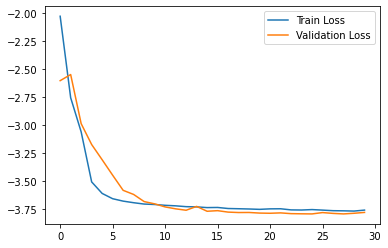

In [132]:
autoencoder3.summary()
pyplot.plot(np.log(history3.history['loss']), label='Train Loss')
pyplot.plot(np.log(history3.history['val_loss']), label='Validation Loss')
pyplot.legend()
pyplot.show()

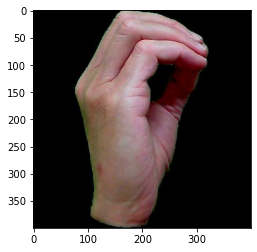

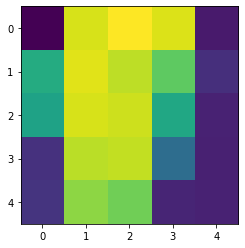

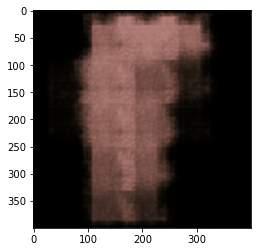

In [88]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder3.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=autoencoder3.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

summary:

Classifiers:
now we'll build 3 different classifiers based on different AutoEncoders with slightly different structure.

In [148]:
class Clasiffier1(keras.Model):
  def __init__(self):
    super(Clasiffier1, self).__init__()
    self.linear = tf.keras.models.Sequential([
        layers.Conv2D(4, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.Conv2D(16, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

  def call(self, x):
    encoded = autoencoder1.encoder(x)
    return self.linear(encoded)
  
clasiffier1=Clasiffier1()

class Clasiffier2(keras.Model):
    def __init__(self):
      super(Clasiffier2, self).__init__()
      self.linear = tf.keras.models.Sequential([
        layers.Conv2D(4, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.Conv2D(16, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

    def call(self, x):
      encoded = autoencoder2.encoder(x)
      return self.linear(encoded)
  
clasiffier2=Clasiffier2()

class Clasiffier3(keras.Model):
    def __init__(self):
      super(Clasiffier3, self).__init__()
      self.linear = tf.keras.models.Sequential([
        layers.Conv2D(4, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Conv2D(16, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

    def call(self, x):
      encoded = autoencoder3.encoder(x)
      return self.linear(encoded)
  
clasiffier3=Clasiffier3()

In [ ]:
clasiffier1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history4 = clasiffier1.fit(X_trainTensor, Y_trainTensor, epochs=200,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Model: "clasiffier1_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_72 (Sequential)  (None, 36)                64732     
                                                                 
Total params: 64,732
Trainable params: 61,532
Non-trainable params: 3,200
_________________________________________________________________


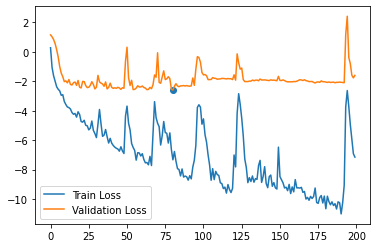

In [150]:
clasiffier1.summary()
pyplot.plot(np.log(history4.history['loss']), label='Train Loss')
pyplot.plot(np.log(history4.history['val_loss']), label='Validation Loss')
lowestIndex=np.argmin(history4.history['val_loss'])
pyplot.scatter(lowestIndex,np.log(history4.history['val_loss'][lowestIndex]))
pyplot.legend()
pyplot.show()

In [ ]:
clasiffier2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history5 = clasiffier2.fit(X_trainTensor, Y_trainTensor, epochs=200,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Model: "clasiffier2_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_73 (Sequential)  (None, 36)                16732     
                                                                 
Total params: 16,732
Trainable params: 15,932
Non-trainable params: 800
_________________________________________________________________


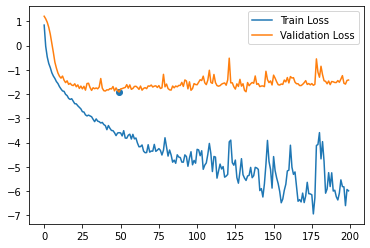

In [152]:
clasiffier2.summary()
pyplot.plot(np.log(history5.history['loss']), label='Train Loss')
pyplot.plot(np.log(history5.history['val_loss']), label='Validation Loss')
lowestIndex=np.argmin(history5.history['val_loss'])
pyplot.scatter(lowestIndex,np.log(history5.history['val_loss'][lowestIndex]))
pyplot.legend()
pyplot.show()

In [ ]:
clasiffier3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history6 = clasiffier3.fit(X_trainTensor, Y_trainTensor, epochs=400,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Model: "clasiffier3_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_74 (Sequential)  (None, 36)                16668     
                                                                 
Total params: 16,668
Trainable params: 15,868
Non-trainable params: 800
_________________________________________________________________


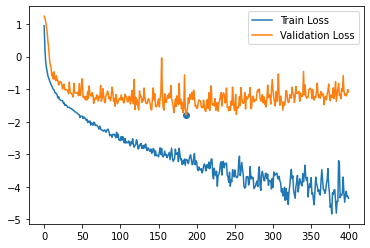

In [154]:
clasiffier3.summary()
pyplot.plot(np.log(history6.history['loss']), label='Train Loss')
pyplot.plot(np.log(history6.history['val_loss']), label='Validation Loss')
lowestIndex=np.argmin(history6.history['val_loss'])
pyplot.scatter(lowestIndex,np.log(history6.history['val_loss'][lowestIndex]))
pyplot.legend()
pyplot.show()

summary:

during the training, accurading to val accuracy, all three models are able to beat 90% accuracy.

we also find clue about the poing that each model will start to overfit.

as a result, we'll pick model 1 and 3, as the most accurate one and the smallest one.

I'll retrain them until the overfit starting point(i.e. 90,190) we got here and then determine the accuracy.

Testing:

accurate model:

In [156]:
class Model1AutoEncoder(keras.Model):
  def __init__(self):
    super(Model1AutoEncoder, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(5, 5),strides=(5, 5), padding='same'),
      layers.Conv2D(2, (3,3), activation = 'relu',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(1, (3,3), activation = 'sigmoid',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
model1AutoEncoder=Model1AutoEncoder()
model1AutoEncoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history7 = model1AutoEncoder.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=60,shuffle=True)

Epoch 1/60
63/63 [==============================] - 68s 1s/step - loss: 0.1297 - val_loss: 0.0750
Epoch 2/60
63/63 [==============================] - 66s 1s/step - loss: 0.0281 - val_loss: 0.0588
Epoch 3/60
63/63 [==============================] - 66s 1s/step - loss: 0.0122 - val_loss: 0.0616
Epoch 4/60
63/63 [==============================] - 66s 1s/step - loss: 0.0102 - val_loss: 0.0568
Epoch 5/60
63/63 [==============================] - 67s 1s/step - loss: 0.0094 - val_loss: 0.0510
Epoch 6/60
63/63 [==============================] - 67s 1s/step - loss: 0.0090 - val_loss: 0.0432
Epoch 7/60
63/63 [==============================] - 66s 1s/step - loss: 0.0088 - val_loss: 0.0314
Epoch 8/60
63/63 [==============================] - 66s 1s/step - loss: 0.0086 - val_loss: 0.0210
Epoch 9/60
63/63 [==============================] - 66s 1s/step - loss: 0.0084 - val_loss: 0.0160
Epoch 10/60
63/63 [==============================] - 68s 1s/step - loss: 0.0084 - val_loss: 0.0106
Epoch 11/60
63/63 [

In [ ]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=model1AutoEncoder.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=model1AutoEncoder.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [ ]:
model1AutoEncoder.summary()
pyplot.plot(np.log(history7.history['loss']), label='Train Loss')
pyplot.plot(np.log(history7.history['val_loss']), label='Validation Loss')
pyplot.legend()
pyplot.show()

In [ ]:
class Model1Clasiffier(keras.Model):
  def __init__(self):
    super(Model1Clasiffier, self).__init__()
    self.linear = tf.keras.models.Sequential([
        layers.Conv2D(4, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.Conv2D(16, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

  def call(self, x):
    encoded = model1AutoEncoder.encoder(x)
    return self.linear(encoded)
  
model1 = Model1Clasiffier()
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history8 = model1.fit(X_trainTensor, Y_trainTensor, epochs=90,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

In [ ]:
model1.summary()
pyplot.plot(np.log(history8.history['loss']), label='Train Loss')
pyplot.plot(np.log(history8.history['val_loss']), label='Validation Loss')
pyplot.legend()
pyplot.show()

In [ ]:
y_pred=model1.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
print(classification_report(y_pred, labelEnc_test))

In [ ]:
cmatrix = confusion_matrix(y_pred, labelEnc_test)
fig, ax = plt.subplots(figsize=(15, 15))
sn.heatmap(cmatrix,annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predictied Labels');ax.set_ylabel('True Labels');
ax.set_title('Confusion Matrix')

SmallModel

In [ ]:
class Model2AutoEncoder(keras.Model):
  def __init__(self):
    super(Model2AutoEncoder, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(4, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(2, (3,3),strides=1,activation="relu",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(1, (3,3),strides=1,activation="sigmoid",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(3,3),strides=1,activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
model2AutoEncoder=Model2AutoEncoder()
model2AutoEncoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history9 = model2AutoEncoder.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=60,shuffle=True)

In [ ]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=model2AutoEncoder.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=model2AutoEncoder.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [ ]:
model2AutoEncoder.summary()
pyplot.plot(np.log(history9.history['loss']), label='Train Loss')
pyplot.plot(np.log(history9.history['val_loss']), label='Validation Loss')
pyplot.legend()
pyplot.show()

In [ ]:
class Model2Clasiffier(keras.Model):
    def __init__(self):
      super(Model2Clasiffier, self).__init__()
      self.linear = tf.keras.models.Sequential([
        layers.Conv2D(4, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Conv2D(16, (3,3), activation = 'relu',strides=1,padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

    def call(self, x):
      encoded = model2AutoEncoder.encoder(x)
      return self.linear(encoded)
  
model2 = Model2Clasiffier()
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history8 = model1.fit(X_trainTensor, Y_trainTensor, epochs=190,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

In [ ]:
y_pred=model1.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
print(classification_report(y_pred, labelEnc_test))